<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовим-данные" data-toc-modified-id="Подготовим-данные-1">Подготовим данные</a></span></li><li><span><a href="#Изучим-и--проверим-данные" data-toc-modified-id="Изучим-и--проверим-данные-2">Изучим и  проверим данные</a></span></li><li><span><a href="#Изучим-воронку-событий" data-toc-modified-id="Изучим-воронку-событий-3">Изучим воронку событий</a></span></li><li><span><a href="#Изучим-результаты-эксперимента" data-toc-modified-id="Изучим-результаты-эксперимента-4">Изучим результаты эксперимента</a></span></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-5">Общие выводы</a></span></li></ul></div>

__Описание проекта__

Мы работаем в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 
Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
После этого исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, мы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.



In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mth
# import seaborn as sns


In [2]:
# #пропишем путь к файлу для работы на локальном компьютере и для ревьюера
try:
    df = pd.read_csv(r'C:\Users\logs_exp.csv',sep = '\t')
except:
    df = pd.read_csv('/datasets/logs_exp.csv',sep = '\t')
                     


## Подготовим данные

In [3]:
def showtime(df):
    display("Выведем первые строки  Данных")
    display(df.head())
    display('-'*10)
    display("Выведем информацию по  имеющимся в файле Данным")
    display(df.info())
    display('-'*10)
    display("Есть ли пропуски в  Данных и их количество")
    display(df.isna().sum())
    display('-'*10)
    display("Количество записей")
    display(len(df))
    display('-'*10)
    display("Какое количество дубликатов в  Данных")
    display(df.duplicated().sum())
    
showtime(df) 

'Выведем первые строки  Данных'

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


'----------'

'Выведем информацию по  имеющимся в файле Данным'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

'----------'

'Есть ли пропуски в  Данных и их количество'

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

'----------'

'Количество записей'

244126

'----------'

'Какое количество дубликатов в  Данных'

413

In [4]:
df.duplicated().sum()


413

__Описание данных__

Каждая запись в логе — это действие пользователя, или событие. 
-	EventName — название события;
-	DeviceIDHash — уникальный идентификатор пользователя;
-	EventTimestamp — время события;
-	ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


Вывели часть данных и заметим что название колонок прежде всего нужно привести  к принципу python-style.
Колонка EventTimestamp   имеет числовое обозначение. Нужно его привести  к виду date. 

Всего  244126 записей. Пропусков в данных нет. Выявлено 413  строк-дубликатов, их количество не является  критически важным соотношением  к общему числу записей, от них можно избавиться без  урона к общим данным.


In [5]:
#переименуем колонки
df = df.rename(columns = {'EventName':'event_name', 'DeviceIDHash':'device_id_hash', \
                          'EventTimestamp' :'event_timestamp', 'ExpId' : 'exp_id'})

In [6]:
#удалим дубликаты
df = df.drop_duplicates().reset_index(drop=True)

In [7]:
#создадим колонку в виде timestamp
df['event_time'] = pd.to_datetime(df['event_timestamp'], unit='s')

#создадим колонку в виде  год-месяц-день
df['event_dtime'] = df['event_time'].dt.strftime('%Y-%m-%d')


In [8]:
#Посмотрим  какие данные содержит колонка  'event_name'
df.event_name.unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)


Видим следующие Наименование записей среди событий : MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful,Tutorial.

Далее  буду считать что перевод следующий: Главная страница, Карточки продуктов, Корзина, Подтверждение оплаты, Описание продукта - Туториал (руководство). 

(ИМХО: брала  варианты перевода страниц  по примеру Озона, ЯП того же... ИМХО)

In [9]:
df.exp_id.unique()

array([246, 248, 247])

Также  видим уникальные группы  среди которых распределены пользователи- что подтверждается описанием задачи ранее.

In [10]:
# проверим что все применилось, количество строк уменьшилось после удалени дубликатов, 
# виды  данных в нужном формате, строки  переименованы верно
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int64         
 4   event_time       243713 non-null  datetime64[ns]
 5   event_dtime      243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.2+ MB


___

## Изучим и  проверим данные

__Проверим что  все   даты правильно сконвертировалось и выведем данные по  временному промежутку  
данные которых доступны для нас__

In [11]:
activity = len(df)
print(f'В логе (данных) всего {activity } записей по  всем действиям всех посетителей')

В логе (данных) всего 243713 записей по  всем действиям всех посетителей


In [12]:
visitors = df.device_id_hash.nunique()
print(f'В логе зафиксировано {visitors} уникальных посетителей')

В логе зафиксировано 7551 уникальных посетителей


In [13]:
sobitye = round(activity/visitors,2)
print(f'В  среднем на одного пользователя приходится  {sobitye} событий')

В  среднем на одного пользователя приходится  32.28 событий


In [14]:
#проверим по отдельным  сформированным колонкам
y_min = df['event_dtime'].min()
y_max = df['event_dtime'].max()
display(f'Рассматриваемый период предоставления данных  стартапа  c {y_min} по {y_max} гг.')

'Рассматриваемый период предоставления данных  стартапа  c 2019-07-25 по 2019-08-07 гг.'

In [15]:
# детализация по времени:
y_min = df['event_time'].min()
y_max = df['event_time'].max()
display(f'Рассматриваемый период предоставления данных  стартапа с {y_min} по {y_max} гг.')

'Рассматриваемый период предоставления данных  стартапа с 2019-07-25 04:43:36 по 2019-08-07 21:15:17 гг.'

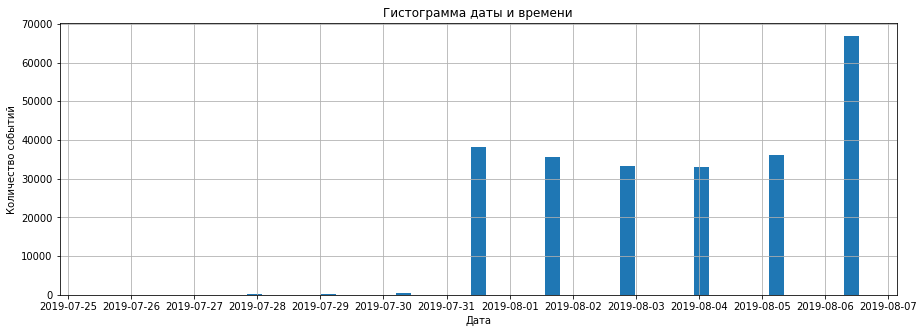

In [16]:
#Построим  гистограмму по дням обнаруженных записей
plt.figure(figsize=(15, 5))

df['event_dtime'].hist(bins = 11, rwidth = 0.2)
plt.title('Гистограмма даты и времени')
plt.xlabel('Дата')
plt.ylabel('Количество событий');

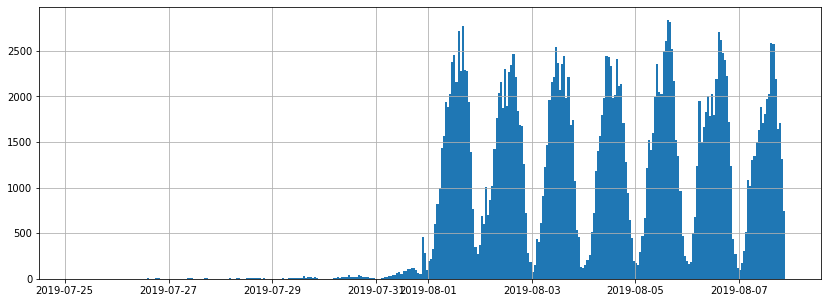

In [17]:
# код ревьюера
df['event_time'].hist(bins=14*24, figsize=(14, 5));


По гистограмме распределения можем видеть что только с 01 августа 2019 года  мы располагаем   большими массивами данных.
Наверное можем удалить  записи   ранее 01 августа 2019.
Попробуем удалить данные до   указанного нами период и подсчитать какое количество они оставляют от всего фрейма данных. Если более 10 %  - дальнейшие действия могли бы подвергнуться критике.
По  записям с  01 августа 2019 по 07 августа 2019  включительно мы сможем сделать оценку действий пользователей.


In [18]:
#Обрежем данные по дате '2019-08-01'
cut = df[df['event_dtime']>='2019-08-01'] 
print(f'Новый датафрейм, по  отфильтрованным данным содержит {len(cut)} записей')

Новый датафрейм, по  отфильтрованным данным содержит 240887 записей


In [19]:
razn = len(df) - len(cut)
print(f'Разница между датафреймом без дубликатов, df и отфильтрованным по дате "2019-08-01" составляет {razn} строк')
proc = (razn * 100)/len(df)
print(f'Что составляет {round(proc,2)} процента от первоначального кол-ва строк')

Разница между датафреймом без дубликатов, df и отфильтрованным по дате "2019-08-01" составляет 2826 строк
Что составляет 1.16 процента от первоначального кол-ва строк


In [20]:
#Расчитаем сколько уникальных пользователей было  до и после определения актуального временного 
# промежутка, вычтем, узнаем  скольких лишились и  важно ли их количество
df_polz = df.device_id_hash.nunique()
cut_polz = cut.device_id_hash.nunique()
udaleno = df_polz - cut_polz
p = (udaleno/df_polz)*100
print(f' При  определении  актуального временного промежутка  мы удалили: {udaleno} пользователей')
print(f' До  определения  актуального временного промежутка  было: {df_polz} пользователей')
print(f' Соотношение удаленных {udaleno} польз-ей  к начальным {df_polz} некритично, составляет {round(p,2)} %')

 При  определении  актуального временного промежутка  мы удалили: 17 пользователей
 До  определения  актуального временного промежутка  было: 7551 пользователей
 Соотношение удаленных 17 польз-ей  к начальным 7551 некритично, составляет 0.23 %


Удаление  строк не является критически важным. Далее  расчеты покажут актуальную информацию.

In [21]:
#выведем категории событий в cut 
cut.event_name.unique()

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

In [22]:
#выведем группы в cut          
cut.exp_id.unique()

array([246, 247, 248])

При удалении части строк группы и категории сохранились. Можем работать далее.

In [23]:
#Узнаем сколько записей в каждой из групп

group_246 = len(cut[cut['exp_id'] == 246])
group_247 = len(cut[cut['exp_id'] == 247])
group_248 = len(cut[cut['exp_id'] == 248])
print(f' В группе 246: {group_246} записей')
print(f' В группе 247: {group_247} записей')
print(f' В группе 248: {group_248} записей')

 В группе 246: 79302 записей
 В группе 247: 77022 записей
 В группе 248: 84563 записей


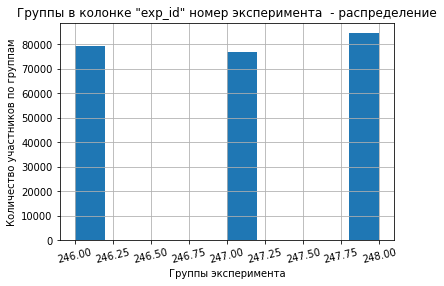

In [24]:
# Построим гистограмму распределения записей по группам
cut.exp_id.hist()
plt.title('Группы в колонке "exp_id" номер эксперимента  - распределение')
plt.xlabel('Группы эксперимента')
plt.ylabel('Количество участников по группам');
plt.xticks(rotation=13);

In [25]:
# #создадим 3 отдельные группы с  общим номером группы
# group_246 = len(cut[cut['exp_id'] == 246])
# group_247 = len(cut[cut['exp_id'] == 247])
# group_248 = len(cut[cut['exp_id'] == 248])

In [27]:
unique_by_groups = cut.groupby('exp_id').agg({'device_id_hash':'nunique'})
unique_by_groups

,device_id_hash
exp_id,
246,2484
247,2513
248,2537


In [28]:
users = len_id_246+len_id_247+len_id_248
users

7534

В процессе сортировки по дате в фрейме данных осталось 7534 пользователя

___

## Изучим воронку событий

__Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.__

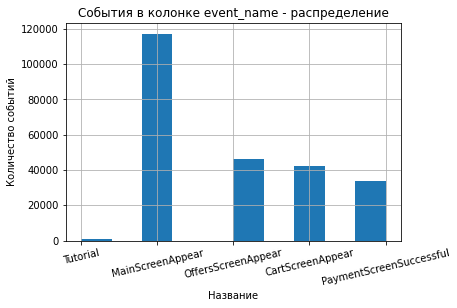

In [29]:
#построим гистограмму - распределние  событий в колонке event_time
cut.event_name.hist()
plt.title('События в колонке event_name - распределение')
plt.xlabel('Название')
plt.ylabel('Количество событий');
plt.xticks(rotation=13);

__Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.__

In [30]:
event_to_hash = cut.groupby('event_name').agg({'device_id_hash':'count'})
event_to_unique = cut.groupby('event_name').agg({'device_id_hash':'nunique'})

cumulative_data = event_to_hash.merge(event_to_unique, left_on=['event_name'],right_on=['event_name'])
cumulative_data.columns = ['sum_log', 'count_id']
cumulative_data.sort_values(by='count_id', ascending = False)   

,sum_log,count_id
event_name,,
MainScreenAppear,117328,7419
OffersScreenAppear,46333,4593
CartScreenAppear,42303,3734
PaymentScreenSuccessful,33918,3539
Tutorial,1005,840


Наибольшее ко-во  записей зарегистрировано по  убыванию: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful,Tutorial.

Видим что  кол-во  пользователей по  событиям в колонке "exp_id" также не одинаково.

In [31]:
#мы знаем сколько всего в группах  уникальных пользователей. Также знаем сколько уникльных пользователей прошло в каждое
# из окон. Можем посчитать  конверсии переходов.

voronka = (event_to_unique/users)*100
round(voronka.sort_values(by = 'device_id_hash', ascending=False),2)

,device_id_hash
event_name,
MainScreenAppear,98.47
OffersScreenAppear,60.96
CartScreenAppear,49.56
PaymentScreenSuccessful,46.97
Tutorial,11.15


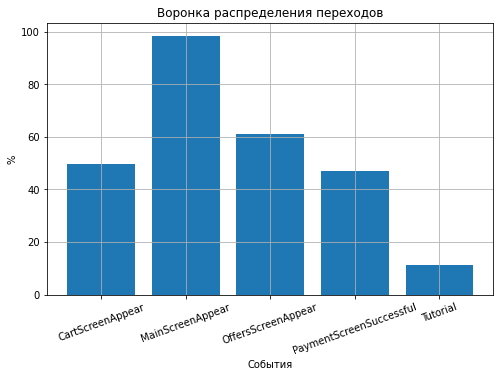

In [32]:
#Построим для визуализации   разницу в переходах

plt.figure(figsize=(8, 5))
plt.bar(voronka.index, voronka.device_id_hash)
plt.title('Воронка распределения переходов')
plt.xlabel('События')
plt.ylabel('%');
plt.xticks(rotation=20)
plt.grid(True);
plt.show();

Как мы видим, постепенно, не обходя другие окна  или прыгая через них пользователи спускаются  к "Руководству".

Наибольший процент конвертации пользователей  на Главную страницу - 98,47 процентов,  Карточки продуктов смотрят уже 60,96 процентов(разница в 38 процентов!!), до Корзиной проходит 49,56 процентов и также отмечаем большую разницу (более 35 процентов) между  Подтверждением оплаты  - 46,97 процентов и  Руководством - 11,15 процентов.
Разница между  конвертацией в Корзину и Подтверждением оплаты - минимальная: 49.56-46.97 процентов!

До оплаты доходит только  47 процентов посетителей.



Посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [33]:
event_to_unique.reset_index()
# отсортируем 
event_to_unique = event_to_unique.sort_values(by='device_id_hash', ascending = False)   
# разделим  с помощью функц.shift  последующие показатели на предыдущие 
event_to_unique['perehod'] = (event_to_unique['device_id_hash']/event_to_unique\
                                            ['device_id_hash'].shift(1))
#выясним наши потери 
event_to_unique['potery'] = round((1-event_to_unique['perehod'])*100,2)
event_to_unique


,device_id_hash,perehod,potery
event_name,,,
MainScreenAppear,7419,NaN,NaN
OffersScreenAppear,4593,0.619086,38.09
CartScreenAppear,3734,0.812976,18.70
PaymentScreenSuccessful,3539,0.947777,5.22
Tutorial,840,0.237355,76.26


Можем увидеть  что  при переходе с одного шага на другой  мы имеем не такие серьезные потери если сравнивать  с соотношением Главного окна к  Карточкам продуктов.
Потери при переходе   на Руковододство(Tutorial) самые большие.

п.с. - кто и  когда читает инструкции?

___

## Изучим результаты эксперимента

__Сколько пользователей в каждой экспериментальной группе?__

In [34]:
g_246 = cut[cut['exp_id'] == 246]
g_247 = cut[cut['exp_id'] == 247]
g_248 = cut[cut['exp_id'] == 248]

len_id_246 = g_246['device_id_hash'].nunique()
len_id_247 = g_247['device_id_hash'].nunique()
len_id_248 = g_248['device_id_hash'].nunique()

print(f' Количество  уникальных пользователей в группе 246:  {len_id_246} пользователя')
print(f' Количество  уникальных пользователей в группе 247:  {len_id_247} пользователя')
print(f' Количество  уникальных пользователей в группе 248:  {len_id_248} пользователя')

 Количество  уникальных пользователей в группе 246:  2484 пользователя
 Количество  уникальных пользователей в группе 247:  2513 пользователя
 Количество  уникальных пользователей в группе 248:  2537 пользователя


Посмотрим  не попали ли  пользователи одних групп в другие.

In [35]:
len(np.intersect1d(cut.query('exp_id == 246')['device_id_hash'], cut.query(
'exp_id == 247')['device_id_hash'], assume_unique = False))

0

In [36]:
len(np.intersect1d(cut.query('exp_id == 247')['device_id_hash'], cut.query(
'exp_id == 248')['device_id_hash'], assume_unique = False))

0

In [37]:
len(np.intersect1d(cut.query('exp_id == 246')['device_id_hash'], cut.query(
'exp_id == 248')['device_id_hash'], assume_unique = False))

0

,device_id_hash
exp_id,
246,2484
247,2513
248,2537


/tmp/ipykernel_455/4288597973.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(1, 1, 1)


<Figure size 720x360 with 0 Axes>

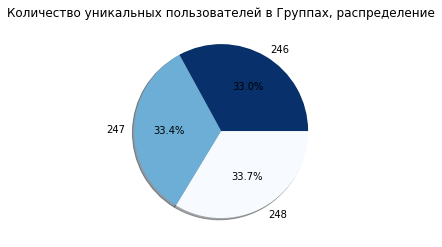

In [38]:
gr = cut.groupby('exp_id').agg({'device_id_hash':'nunique'})

display(gr)
plt.figure(figsize=(10, 5))
gr.plot(kind = 'pie', subplots=True, shadow = True, legend=False, autopct='%.1f%%', cmap="Blues_r")
ax1 = plt.subplot(1, 1, 1)
plt.title('Количество уникальных пользователей в Группах, распределение')
ax1.axes.yaxis.set_visible(False)
plt.show();


In [39]:
graf =  gr.copy()

display(graf)
new = 2484+2513
graf.loc[2467] = [4997]
display(new)
display(graf)

,device_id_hash
exp_id,
246,2484
247,2513
248,2537


4997

,device_id_hash
exp_id,
246,2484
247,2513
248,2537
2467,4997


In [40]:
g_246_time_min = g_246['event_dtime'].min()
g_246_time_max = g_246['event_dtime'].max()
print(f' Данные группы "g_246" включают  период с {g_246_time_min}  по {g_246_time_max}')

g_247_time_min = g_247['event_dtime'].min()
g_247_time_max = g_247['event_dtime'].max()
print(f' Данные группы "g_247" включают  период с {g_247_time_min}  по {g_247_time_max}')

g_248_time_min = g_248['event_dtime'].min()
g_248_time_max = g_248['event_dtime'].max()
print(f' Данные группы "g_247" включают  период с {g_248_time_min}  по {g_248_time_max}')

 Данные группы "g_246" включают  период с 2019-08-01  по 2019-08-07
 Данные группы "g_247" включают  период с 2019-08-01  по 2019-08-07
 Данные группы "g_247" включают  период с 2019-08-01  по 2019-08-07


Сравнения  уникальных id  показал что пользователи во всех исследуемых группах - уникальные и характерны только их группам, нет пользователей которые  были замечены и в альтернативной.

Также отметим что  все группы охватывают один временной промежуток.

___

In [41]:
dates = cut.groupby('exp_id').agg({'event_dtime':['min','max']})
dates

event_dtime            
               min         max
exp_id                        
246     2019-08-01  2019-08-07
247     2019-08-01  2019-08-07
248     2019-08-01  2019-08-07

__Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов, проверим, находят ли статистические критерии разницу между выборками 246 и 247.__

__Напомню что 246 и 247 — контрольные группы, а 248 — экспериментальная.__

Уровень статистической значимости — это вероятность случайно получить в реальном наблюдении значение, далёкое от предполагаемого в нулевой гипотезе.

Уровень статистической значимости — это одновременно и вероятность ошибиться: отвергнуть нулевую гипотезу, потому что наблюдение отличается от предполагаемого значения слишком сильно. 
Такая ошибка называется ошибкой первого рода, или ложнопозитивным результатом статистического теста. Это означает, что различий между сравниваемыми группами нет, но тест показал p-value меньше уровня значимости. Получается, есть основания отвергнуть H₀. Так, вероятность ошибки первого рода равна уровню значимости α.
Ошибка второго рода — ложнонегативный результат. Он указывает, что различия между группами есть, но тест показал p-value больше уровня значимости α и нет оснований отвергать H₀. Если обозначить вероятность ошибки второго рода как β, то параметр 1 - β будет называться мощностью статистического теста. Раз β — вероятность ошибиться, то 1 - β — вероятность не ошибиться, то есть правильно отклонить нулевую гипотезу, когда она неверна.

Прежде всего хочу избавиться от балласта под названием "Tutorial" -  к инструкцию пользования (чего? как употреблять продукты?? - цель  мануала не ясна)  переходит не так много пользователей. На сколько может быть  понятно из воронок  по группам, переход на это окно не влияет на активность и действия пользователей. Если только это не является маркетинговым ходом  типа "Миссии предприятия", которая используется повсеместно и  носит репутационных характер.

In [46]:
#Создадим таблицу переходов   на страницы приложения по контроьной группе а = 246
a_group = g_246.groupby('event_name')['device_id_hash'].nunique().sort_values(ascending=False).reset_index() # группируем
#поделим количество переходов по страничкам на  уникальных клиентов в группе
a_group = a_group.query('event_name  !="Tutorial"')
print(a_group)
print ('-'*10)

# Создадим таблицу переходов   на страницы приложения по контроьной группе аа = 247

aa_group = g_247.groupby('event_name')['device_id_hash'].nunique().sort_values(ascending=False).reset_index() # группируем
#поделим количество переходов по страничкам на  уникальных клиентов в группе
aa_group = aa_group.query('event_name  !="Tutorial"')
print(aa_group)
print ('-'*10)

#Создадим таблицу переходов   на страницы приложения по контрольной группе в = 248
b_group = g_248.groupby('event_name')['device_id_hash'].nunique().sort_values(ascending=False).reset_index() # группируем
#поделим количество переходов по страничкам на  уникальных клиентов в группе
# b_group['perehod'] = round(b_group['device_id_hash']/len_id_248*100,)
b_group = b_group.query('event_name  !="Tutorial"')
print(b_group)
print ('-'*10)

#Создадим смешанную группировку  246 и 247
aaa_group=a_group.merge(aa_group, on='event_name')
aaa_group['device_id_hash']=aaa_group['device_id_hash_x']+aaa_group['device_id_hash_y']
aaaa_group = aaa_group[['event_name','device_id_hash']].copy()
print(aaaa_group)


                event_name  device_id_hash
0         MainScreenAppear            2450
1       OffersScreenAppear            1542
2         CartScreenAppear            1266
3  PaymentScreenSuccessful            1200
----------
                event_name  device_id_hash
0         MainScreenAppear            2476
1       OffersScreenAppear            1520
2         CartScreenAppear            1238
3  PaymentScreenSuccessful            1158
----------
                event_name  device_id_hash
0         MainScreenAppear            2493
1       OffersScreenAppear            1531
2         CartScreenAppear            1230
3  PaymentScreenSuccessful            1181
----------
                event_name  device_id_hash
0         MainScreenAppear            4926
1       OffersScreenAppear            3062
2         CartScreenAppear            2504
3  PaymentScreenSuccessful            2358


Сложим группы 246 и 247 вместе и сравним с данными группы 248

Сравним пропорций двух контрольных групп по количеству переходов пользователей по страницам приложения. Одинаковые (пропорциональное отношение) ли  действие они  совершают?

Нулевая  гипотеза Н0 - доли уникальных посетителей, побывавших на этапе воронки одинаковы,  разницы нет.
Альтернативная гипотеза Н1 - между долями уникальных посетителей, побывавших на этапе воронки разница  в пропорциях есть.


Создадим функцию для расчета  z - теста для расчета пропорций указанных выше

In [47]:
def sravnim(first, second, n1,n2):

    for i in range(len(first)):
        successes = np.array([first.loc[i, 'device_id_hash'], second.loc[i, 'device_id_hash']])
        trials = (np.array([n1, n2,]))
    

        p1 = successes[0]/trials[0] # пропорция успехов в первой группе

        p2 = successes[1]/trials[1] # пропорция успехов во второй группе

        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1]) # пропорция успехов 
    
        alpha = .05 # критический уровень статистической значимости

        difference = p1 - p2  # разница пропорций в группах
# считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1]))

        distr = st.norm(0, 1) # задаем стандартное нормальное распределение

        p_value = (1 - distr.cdf(abs(z_value))) * 2
        event_name = first['event_name']
        print(f'P-значение для {event_name[i]}: {p_value}')

        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        print('*'*10)

__Выберим самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий . Можно ли сказать, что разбиение на группы работает корректно?__

Сравним пропорций двух групп 246 и 247 по количеству переходов пользователей по страницам приложения. Одинаковые (пропорциональное отношение) ли  действие они  совершают?

Нулевая  гипотеза Н0 - пропорции одинаковы,  разницы нет.
Альтернативная гипотеза Н1 - разница  в пропорциях есть.

In [55]:
# event_name = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
sravnim(a_group,aa_group,graf.iloc[0,0],graf.iloc[1,0])

P-значение для MainScreenAppear: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**********
P-значение для OffersScreenAppear: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**********
P-значение для CartScreenAppear: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**********
P-значение для PaymentScreenSuccessful: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**********


Согласно проведенным тестам можем не отвергать выдвинутые Нулевые гипотезы  о  равенстве пропорций.
Пользователи совершают  ОЧЕНЬ похожие движения  MainScreenAppear - 0.75705972, далее  расходятся данные но в пределах установленного нами уровня статистической значимости - альфа(0,05).
Группы 246 и 247 похожи по сегментам переходов.


___

Сравним пропорций двух групп 246 и 248 по количеству переходов пользователей по страницам приложения. Одинаковые (пропорциональное отношение) ли действие они совершают?

Нулевая гипотеза Н0 - пропорции одинаковы, разницы нет. Альтернативная гипотеза Н1 - разница в пропорциях есть.

In [56]:
sravnim(a_group,b_group,graf.iloc[0,0],graf.iloc[2,0])

P-значение для MainScreenAppear: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**********
P-значение для OffersScreenAppear: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**********
P-значение для CartScreenAppear: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**********
P-значение для PaymentScreenSuccessful: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**********


Согласно проведенным тестам можем не отвергать выдвинутые Нулевые гипотезы о равенстве пропорций уже между одной из контрольных и тестовой (с новым шрифтом) страницы. Пользователи  совершают ОЧЕНЬ похожие движения по всем страницам, а вот у CartScreenAppearpear - всего 7,8 %.. еще бы немного и при нашем  p-value показали бы  уже критические данные и  на этом этапе  диагностировали что пропорции важные,а так  соотношения групп  выше уровеня статистической значимости - альфа(0,05). 

___

Сравним пропорций двух групп 247 и 248 по количеству переходов пользователей по страницам приложения. Одинаковые (пропорциональное отношение) ли  действие они  совершают?

Нулевая  гипотеза Н0 - пропорции одинаковы,  разницы нет.
Альтернативная гипотеза Н1 - разница  в пропорциях есть.

In [57]:
sravnim(aa_group,b_group,graf.iloc[1,0],graf.iloc[2,0])

P-значение для MainScreenAppear: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**********
P-значение для OffersScreenAppear: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**********
P-значение для CartScreenAppear: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**********
P-значение для PaymentScreenSuccessful: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**********


Согласно проведенным тестам можем не отвергать выдвинутые Нулевые гипотезы  о  равенстве пропорций только в отношение Главных страниц между группами 247 и 248. но далее  пропорции нет  статистически значимых различий в ппропорциях переходов в пределах установленного нами уровеня статистической значимости - альфа(0,05).


___

Сравним пропорций  сложенных двух групп 246+247 и 248 по количеству переходов пользователей по страницам приложения. Одинаковые (пропорциональное отношение) ли  действие они  совершают?

Нулевая  гипотеза Н0 - пропорции одинаковы,  разницы нет.
Альтернативная гипотеза Н1 - разница  в пропорциях есть.

In [58]:
sravnim(aaaa_group,b_group,graf.iloc[3,0], graf.iloc[2,0])

P-значение для MainScreenAppear: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**********
P-значение для OffersScreenAppear: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**********
P-значение для CartScreenAppear: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**********
P-значение для PaymentScreenSuccessful: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**********


Мы получили расчеты которые  снова  не позволяют отвергнуть Нулевую гипотезу о равенстве  долей в комбинированном 246+247 группа  с 248 группой.


Что можно на этом основании вынести - изменения в шрифте дизайнеров которые  предпологали опасения маркетологов не  вызвали опасения пользователей. Поведение  пользователей кардинально не изменилась и  активность не уменьшилась. 


__Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.__

Было выбрано p-value максимальное 0,05. 0,01 также можно было применить, но  для чистоты эксперимента этот коэффициент (0,05) применялся ко всем 16 расчетам по  группам данных котоыре нам предоставили. Если бы мы применили 0,01 p-value то согласно показателям никакой роли это не сыграло. Так что смысла менять условия и  по новым показателям сравнивать данные  нет. В том  числе даже если каждый десятый результат будет ложным.  

П.с. - в след. раз маркетологов можно попросить предоставить описание окон на русском языке для дальнешей адекватной оценки передвижений пользователей по окнам приложения. Это уменьшит время осознания и поиска адекватного перевода, что  повлияет на скорость  принятия решений аналитиков.

## Общие выводы

Интересно почему такая градация распределения по группам:246	- 2484 уникальных пользователя. 247	- 2513 пользователя и 248	- 2537 даже с учетом  удаленных нами юзеров  которые  существовали до 1 августа, соотношение неодинаковое. Нет уточнения когда старт изменений был осуществляет. если с 1 августа- вопросы отпадают, если ранее - возможно настройки для сбора  логов не  было. Возникло много вопросов по данным  к маркетологам этого  проекта.
'Рассматриваемый период предоставления данных  стартапа  c 2019-07-25 по 2019-08-07 гг.' Либо стендапперам было жалко денег на отслеживание  изменений и анализ, либо кто-то неправильно посчитал в калькуляторе сроки проведения тестирования, интересно было бы  узнать какие параметры они вводили при расчете, а может вовремя не запустил тестирование, но  за сроки полных данных, от 1 августа за 7 дней понять и рассчитать алгоритм пользователей адекватно малоправдоподобно. 

Если  ВЕСЬ период   тестирования приходился на   промежуток меду праздниками и рабочими днями - то разрыв в данных (объем) очень  даже  понятен, но опять же вопросы -  адекватно оценить  уровень  восприятия нового шрифта пользователями  трудно. 

Можно было бы разбить по датам группы по объему покупок (посчитали бы еще и сколько потратили) и сделать еще и эти сравнения.

Еще вопрос к контрольным группам - они разбивались по  планшетам и телефонам (у нас же мобильное приложение)  или под конкретную мобильную платформу (iOS, Android, Windows Phone). Обычно приложение разрабатывается на языке высокого уровня и компилируется в нативный код ОС, дающий максимальную производительность.

Маркетологам бы  рекомендовала  рассмотреть доп. группы тестирования, увеличить количество контрольных групп, к примеру именно под платформу, увеличить срок  сбора данных (проверить верность вводимых критериев для сбора информации) возможно их пересмотреть. Помимо прочего, если все рассчитано верно изменить сроки тестирования  собрать данные не в Пиковые дни, к примеру   под праздники, тот же Новый год, когда все  практически оптово закупаются, а в обычные рабочие дни + стандартные  субботу и вскр. - как пользователи реагируют  и в выходные дни.
